In [1]:
import sys
print(sys.version) # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [2]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

In [4]:
print("Tensorflow version: ", tf.VERSION) # 1.13.1
print("Keras version: ", tf.keras.__version__) # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

# from tensorflow.python.client import device_lib
# print('List of GPUs:\n',
#       [x for x in device_lib.list_local_devices()
#        if x.device_type == "GPU" or x.device_type == "SYCL"])

Tensorflow version:  1.13.1
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  False


# SmallerVGGNet, with noise layer added

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [5]:
filename = 'nodes_16'

path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

predict_only = True
predict_test_only = False

pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))


In [6]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # add black & white noise to input data
        if chanDim == -1:
            noiseShape = (height, width, 1)
        else:
            noiseShape = (1, height, width)
            
        model.add(Dropout(0.2, noise_shape=noiseShape,
                          input_shape=inputShape)) # black
        model.add(Lambda(lambda x: 1 - x)) # 0 to 1, 1 to 0
        model.add(Dropout(0.1, noise_shape=noiseShape)) # white
        model.add(Lambda(lambda x: 1 - x))
        model.add(Activation("relu"))
           
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(16, name='learned_representation'))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(1))

        # return the constructed network architecture
        return model

In [7]:
path_model = "/data/" + filename + ".h5"
dir_model = os.path.dirname(path_model)

pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [8]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 1

def _parse_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['norm_year']

def create_dataset(filepath):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

train_dataset = create_dataset(path_train_tfrecord)
test_dataset =  create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

In [9]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2],
)

for images,labels in train_dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())
    
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Logits:  [[-0.06521525]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 6)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
______________________________________________________________

In [10]:
model.compile(optimizer='RMSprop', 
              loss='mean_squared_error')

Instructions for updating:
Use tf.cast instead.


In [11]:
with h5py.File(path_model,'r') as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
        
model.set_weights(weight)
# weight

In [12]:
def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [13]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [14]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
predictions = model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

predictions = [x[0] for x in predictions]
# predictions

In [15]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
for batch in iter:
    ids.extend(batch[1].numpy())

ids = [x.decode() for x in ids]
# ids

In [16]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

true_year = []
for batch in iter:
    true_year.extend(batch[2].numpy())

# true_year

In [17]:
df = pd.DataFrame(zip(ids, true_year, predictions), columns=['ID', 'true_year', 'prediction'])
df['row'] = np.arange(len(df))
df

,ID,true_year,prediction,row
0,2829_105,0.520000,0.588902,0
1,999_37,0.360000,0.477967,1
2,7770_55A,0.200000,0.394336,2
3,2140_92B,0.520000,0.503924,3
4,509_73,0.500000,0.526380,4
5,19478_113,0.740000,0.752904,5
6,8657_70,0.360000,0.414310,6
7,1856_61,0.400000,0.459103,7
8,25606_107C,0.740000,0.751057,8
9,27502_140B,0.840000,0.815377,9


In [18]:
corr_year = df.true_year.corr(df.prediction)

r2_text = format(corr_year**2, '.3f')
r2_text = '$r^2 = ' + r2_text + '$'

if predict_test_only: 
    r2_text += '\n(Test dataset only)'
    
r2_text

'$r^2 = 0.898$'

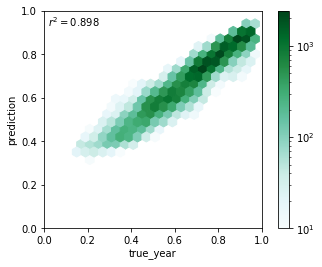

In [19]:
ax = df.plot.hexbin(x='true_year',y='prediction',
                    extent=(-0.03,1.01,-0.03,1.01), xlim=(0,1), ylim=(0,1), 
                    sharex=False, gridsize=26,
                    bins='log', mincnt=10,
                   )
ax.set_facecolor('w')
ax.set_aspect('equal')
ax.text(0.02,0.98,r2_text, verticalalignment='top')
fig = ax.get_figure()

if predict_test_only: 
    dataset_tag = "_testonly"
else:
    dataset_tag = ""

# fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".pdf")
# fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".png")

In [20]:
# !cp /data/{filename}* .

In [22]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

layer_name = 'learned_representation'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
intermediate_output = intermediate_layer_model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

intermediate_output.shape

(50540, 16)

In [23]:
X = pd.DataFrame(intermediate_output)
y_pred = df['prediction']
y_true = df['true_year']

In [24]:
print(X.shape, y_pred.shape)

(50540, 16) (50540,)


In [25]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,1027.030762,3590.459229,2449.201172,3199.279785,3634.962158,2639.888184,3459.438477,3494.077393,3469.074707,3508.016357,1903.669922,2835.505859,3649.077881,3050.489990,3940.739502,3576.219482
std,1648.398193,1638.998657,833.820007,2872.885986,1633.613770,633.334534,1540.654907,1583.723877,1548.189941,1661.084961,1584.282227,3004.859619,1835.982788,1180.520874,2582.145996,1629.033813
min,-5973.604980,-5964.641602,-119.080353,-29197.759766,-7203.070801,237.281006,-6885.991211,-5916.401855,-6763.536133,-6148.786621,-3513.331543,-33055.347656,-7805.885254,-313.402130,-20184.128906,-6163.144043
25%,259.275314,2414.803467,1886.418640,1662.886536,2515.677551,2187.744995,2398.962769,2361.128906,2365.079834,2319.083191,929.760406,1500.551361,2379.225891,2150.005432,2338.756104,2386.397705
50%,1106.990112,3798.149780,2287.469238,3677.741333,3788.501953,2535.211060,3624.154419,3694.549072,3653.040771,3727.268311,1788.642334,3366.343872,3916.028442,2689.737793,4326.779297,3743.634521
75%,2101.949951,4952.373291,2929.486267,5577.697632,4985.046875,3025.599487,4723.801392,4848.664062,4798.119873,4891.744263,3002.832214,5203.221924,5138.791260,3953.736816,6112.771118,4913.125610
max,10088.750977,6829.411621,10116.169922,7786.641113,7019.882324,9074.801758,6521.217773,6772.486816,6477.657227,6781.878418,12823.604492,7677.069824,7293.493164,10840.181641,8186.108887,7059.097656


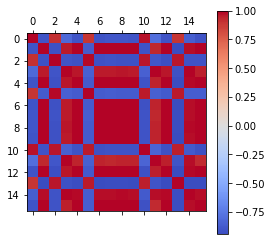

In [26]:
plt.matshow(X.corr(), cmap='coolwarm', norm=DivergingNorm(0)) # no white = high corr
plt.colorbar()
plt.show()

In [48]:
regr = LinearRegression().fit(X, y_pred)
print(regr.score(X, y_pred))
print(format(regr.score(X, y_true), '.3f'), format(corr_year**2, '.3f'))

0.9965884396264157
0.866 0.898


In [28]:
regr.coef_.shape

(16,)

In [29]:
regr.intercept_

0.617249

In [53]:
ica = FastICA(random_state=1106)
ica.fit(X)
X_ica = pd.DataFrame(ica.transform(X))

regr = LinearRegression().fit(X_ica, y_pred)
print(regr.score(X_ica, y_pred))

0.9965884396007952


In [54]:
X_ica

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.002066,-0.000998,0.003840,0.004103,0.001574,-0.001924,-0.007318,-0.004046,-0.003998,-0.002189,-0.000997,-0.009024,0.000183,-0.001739,-0.001959,-0.003882
1,-0.000357,0.002637,0.005401,-0.001085,0.001115,-0.003850,-0.002301,-0.002397,-0.006710,0.007032,-0.002259,-0.008907,-0.002839,-0.001114,0.003882,0.008431
2,0.005836,0.002339,0.000112,-0.007395,0.009622,-0.000563,-0.001875,-0.004916,0.000572,0.026469,0.001023,-0.006145,-0.007562,-0.004766,0.000772,0.008772
3,-0.002772,-0.002312,-0.001246,0.004238,-0.000727,0.003607,-0.002573,0.013074,-0.001835,0.008008,0.001277,0.001273,-0.001181,0.000615,-0.002252,-0.000209
4,-0.003062,0.003934,0.002956,-0.000344,-0.003707,-0.003347,0.010447,-0.001128,-0.006856,0.000958,-0.001614,-0.005679,0.004715,0.019353,0.001166,0.012013
5,-0.001733,0.002969,-0.007046,0.002709,0.001733,0.000689,0.002241,0.001693,-0.003502,0.000202,0.001547,0.010849,0.000530,-0.002371,-0.001207,-0.000593
6,0.006019,0.008200,-0.003394,-0.002143,0.003329,-0.001727,-0.008235,0.004300,-0.002077,0.009298,0.002276,-0.001370,0.010068,0.010549,-0.000708,0.001507
7,-0.000596,0.002018,-0.001299,0.005174,0.000658,-0.003044,-0.000373,0.002538,0.002160,0.020595,0.014931,0.001902,-0.012719,-0.004849,-0.003251,0.005501
8,0.001533,0.001616,-0.003230,-0.000620,0.004140,0.001325,-0.001452,-0.007503,0.000215,-0.000872,-0.002934,0.000228,-0.001898,-0.000122,-0.004144,0.002270
9,0.000332,-0.000945,-0.001599,0.002170,-0.001850,-0.001889,-0.002135,-0.000755,0.006349,-0.001820,-0.001515,-0.000221,0.003423,-0.002283,-0.002961,-0.001337


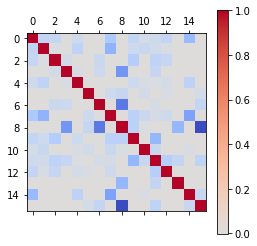

In [56]:
plt.matshow(X_ica.corr(), cmap='coolwarm', norm=DivergingNorm(0)) # no white = high corr
plt.colorbar()
plt.show()

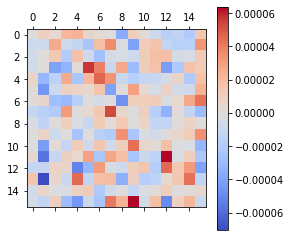

In [55]:
plt.matshow(ica.components_, cmap='coolwarm', norm=DivergingNorm(0)) # more white = less corr
plt.colorbar()
plt.show()

In [57]:
X_ica.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
std,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448
min,-0.039602,-0.040448,-0.033951,-0.064170,-0.074311,-0.327120,-0.048616,-0.071088,-0.015649,-0.031118,-0.057633,-0.049380,-0.077958,-0.097033,-0.015293,-0.066193
25%,-0.001757,-0.002265,-0.003319,-0.002326,-0.002104,-0.001315,-0.002219,-0.002708,-0.003783,-0.002240,-0.001837,-0.002819,-0.002330,-0.002425,-0.002452,-0.002055
50%,-0.000520,0.000217,0.000347,0.000241,0.000067,0.000118,0.000245,-0.000166,-0.000490,-0.000770,-0.000173,-0.000266,-0.000222,-0.000283,-0.000847,-0.000100
75%,0.000733,0.002603,0.003505,0.002489,0.002144,0.001601,0.002546,0.002387,0.003871,0.000817,0.001503,0.002491,0.001889,0.002018,0.001034,0.001911
max,0.101007,0.036004,0.026906,0.150932,0.031824,0.048266,0.064483,0.028389,0.023261,0.051965,0.120676,0.067149,0.060648,0.055489,0.037087,0.057069


In [58]:
X_ica_1std = X_ica*sqrt(50539)
X_ica_1std = X_ica_1std.rename(lambda x: 'factor{}'.format(x), axis='columns')
X_ica_1std.describe()

,factor0,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor8,factor9,factor10,factor11,factor12,factor13,factor14,factor15
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,-8.902812,-9.092987,-7.632523,-14.426007,-16.705857,-73.539435,-10.929309,-15.981312,-3.517981,-6.995499,-12.956311,-11.101071,-17.525752,-21.813970,-3.437890,-14.880681
25%,-0.394919,-0.509255,-0.746173,-0.522877,-0.472941,-0.295627,-0.498876,-0.608676,-0.850563,-0.503659,-0.412913,-0.633827,-0.523819,-0.545208,-0.551128,-0.461960
50%,-0.116913,0.048678,0.077962,0.054234,0.015115,0.026486,0.054986,-0.037234,-0.110222,-0.173186,-0.038796,-0.059763,-0.049829,-0.063621,-0.190409,-0.022445
75%,0.164855,0.585116,0.787915,0.559656,0.482043,0.359822,0.572360,0.536719,0.870228,0.183661,0.337969,0.559968,0.424772,0.453663,0.232347,0.429545
max,22.707188,8.094045,6.048782,33.930876,7.154388,10.850576,14.496303,6.382122,5.229193,11.682167,27.128992,15.095646,13.634265,12.474370,8.337461,12.829692


In [59]:
df = df.join(pd.DataFrame(X_ica_1std))
df

,ID,true_year,prediction,row,factor0,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor8,factor9,factor10,factor11,factor12,factor13,factor14,factor15
0,2829_105,0.520000,0.588902,0,-0.464513,-0.224435,0.863185,0.922475,0.353948,-0.432568,-1.645238,-0.909488,-0.898751,-0.492156,-0.224085,-2.028759,0.041155,-0.390873,-0.440325,-0.872670
1,999_37,0.360000,0.477967,1,-0.080349,0.592726,1.214108,-0.243865,0.250594,-0.865443,-0.517282,-0.538825,-1.508364,1.580783,-0.507879,-2.002376,-0.638138,-0.250353,0.872623,1.895338
2,7770_55A,0.200000,0.394336,2,1.311882,0.525816,0.025082,-1.662356,2.163026,-0.126494,-0.421583,-1.105238,0.128668,5.950542,0.229998,-1.381523,-1.699949,-1.071417,0.173549,1.972093
3,2140_92B,0.520000,0.503924,3,-0.623144,-0.519707,-0.280105,0.952710,-0.163410,0.810983,-0.578373,2.939080,-0.412504,1.800310,0.287124,0.286193,-0.265598,0.138147,-0.506176,-0.047052
4,509_73,0.500000,0.526380,4,-0.688352,0.884359,0.664630,-0.077433,-0.833383,-0.752457,2.348477,-0.253529,-1.541264,0.215410,-0.362746,-1.276660,1.059998,4.350743,0.262060,2.700610
5,19478_113,0.740000,0.752904,5,-0.389640,0.667347,-1.583955,0.608938,0.389561,0.154842,0.503826,0.380493,-0.787341,0.045496,0.347834,2.438908,0.119121,-0.533061,-0.271262,-0.133383
6,8657_70,0.360000,0.414310,6,1.353167,1.843463,-0.763105,-0.481823,0.748348,-0.388187,-1.851320,0.966613,-0.466872,2.090308,0.511689,-0.307896,2.263457,2.371615,-0.159186,0.338866
7,1856_61,0.400000,0.459103,7,-0.133892,0.453699,-0.292103,1.163247,0.147964,-0.684384,-0.083767,0.570551,0.485659,4.629887,3.356716,0.427505,-2.859251,-1.090056,-0.730850,1.236581
8,25606_107C,0.740000,0.751057,8,0.344649,0.363264,-0.726120,-0.139490,0.930731,0.297813,-0.326344,-1.686726,0.048415,-0.195931,-0.659502,0.051286,-0.426726,-0.027355,-0.931667,0.510293
9,27502_140B,0.840000,0.815377,9,0.074683,-0.212398,-0.359383,0.487782,-0.415980,-0.424704,-0.480048,-0.169669,1.427337,-0.409152,-0.340687,-0.049790,0.769465,-0.513310,-0.665707,-0.300464


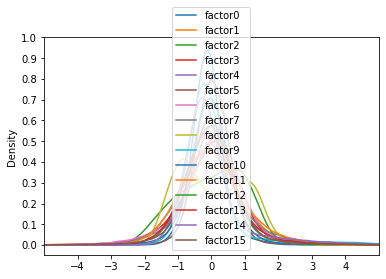

In [60]:
X_ica_1std.plot.kde(xlim=(-5, 5), xticks=range(-4,5), yticks=np.arange(0.,1.01,0.1))

In [62]:
percentile = X_ica_1std.quantile([0.001, 0.01, 0.99, 0.999])
# display(percentile)
display(percentile.T.describe())

,0.001,0.01,0.99,0.999
count,16.000000,16.000000,16.000000,16.000000
mean,-4.158374,-2.134527,2.881138,5.593303
std,1.644240,0.554989,0.852754,2.565198
min,-7.106157,-3.034238,1.368445,2.398031
25%,-5.516238,-2.630215,2.315651,3.899716
50%,-4.128157,-2.143715,2.814308,5.275015
75%,-2.677279,-1.715775,3.245570,6.492022
max,-1.727592,-1.212124,4.430966,11.143819


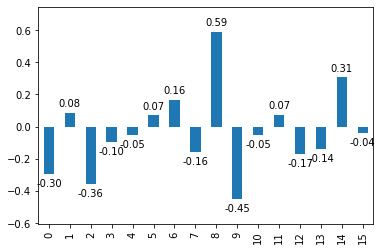

In [63]:
ax = X_ica.corrwith(y_pred).plot.bar()
ax.margins(y=0.15) 
bottom, top = ax.get_ylim()
yrange = top - bottom
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 0.02*yrange*(1 if p.get_height()>=0 else -1),
            format(p.get_height(), '.2f'),
            horizontalalignment='center', 
            verticalalignment='bottom' if p.get_height()>=0 else 'top')

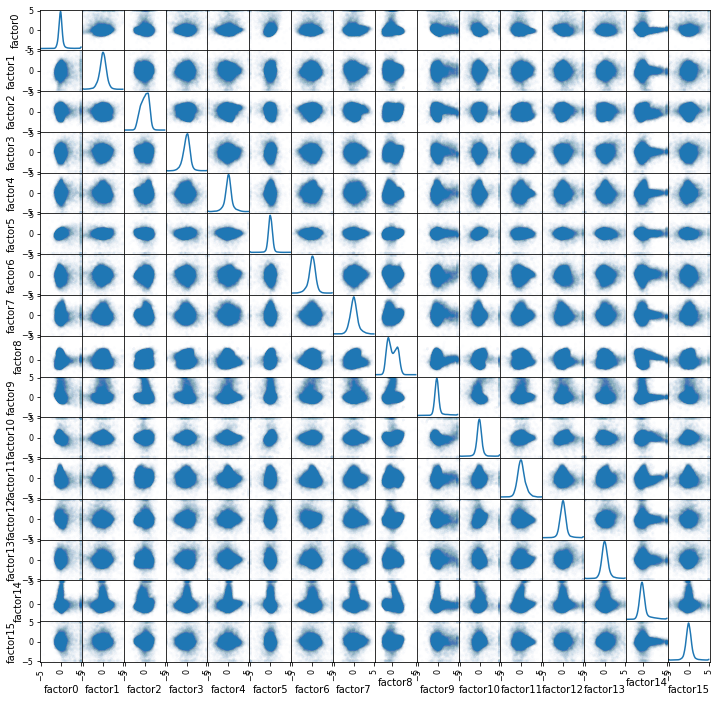

In [64]:
axs = scatter_matrix(X_ica_1std.clip(-5,5), alpha=0.01, figsize=(12, 12), diagonal='kde')

In [66]:
path_csv = "/data/fp_refined.csv"
df_csv = pd.read_csv(path_csv)
df_csv.columns

Index(['id_after', 'Path', 'index', 'APT_ID', 'Date', 'year', 'norm_year',
       'yyyymm', 'N_Housings', 'Max_Floors', 'Min_Floors', 'name', 'emd',
       'emd_name', 'sgg', 'sgg_name', 'sido', 'sido_name', 'sido_cluster',
       'sido_cluster_code', 'sido_sgg_name', 'FP_ID', 'Area', 'norm_log_area',
       'area_85', 'Entrance', 'Rooms', 'Baths', 'N_Units'],
      dtype='object')

In [67]:
if not 'N_Units' in df.columns:
    df = df.join(df_csv[['id_after', 'year',
                         'N_Housings', 'N_Units',
                         'Max_Floors', 'Min_Floors',
                         'sgg', 'sido_sgg_name', 'sido', 'sido_name',
                         'sido_cluster_code', 'sido_cluster',
                         'Area', 'norm_log_area', 'area_85',
                         'Entrance', 'Rooms', 'Baths', 
                        ]].set_index('id_after'), on='ID')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
true_year,50540.000000,0.700838,0.169370,0.000000,0.580000,0.720000,0.820000,1.000000
prediction,50540.000000,0.711228,0.132861,0.178081,0.610513,0.734962,0.817426,0.959868
row,50540.000000,25269.500000,14589.785639,0.000000,12634.750000,25269.500000,37904.250000,50539.000000
factor0,50540.000000,-0.000000,1.000000,-8.902812,-0.394919,-0.116913,0.164855,22.707188
factor1,50540.000000,0.000000,1.000000,-9.092987,-0.509255,0.048678,0.585116,8.094045
factor2,50540.000000,-0.000000,1.000000,-7.632523,-0.746173,0.077962,0.787915,6.048782
factor3,50540.000000,-0.000000,1.000000,-14.426007,-0.522877,0.054234,0.559656,33.930876
factor4,50540.000000,0.000000,1.000000,-16.705857,-0.472941,0.015115,0.482043,7.154388
factor5,50540.000000,-0.000000,1.000000,-73.539435,-0.295627,0.026486,0.359822,10.850576
factor6,50540.000000,-0.000000,1.000000,-10.929309,-0.498876,0.054986,0.572360,14.496303


In [68]:
df.to_csv('/data/fp_ica16.csv')